In [ ]:
#default_exp prototypes

In [ ]:
#hide
from andi_unicorns.models import *
from andi_unicorns.data import get_discriminative_dls, get_custom_dls, validate_task

from fastai.vision.all import *
from fastai.text.all import *

%load_ext autoreload
%autoreload 2

# Prototypes
> Prototyping for different tasks

## Task 1 -- Regression

Task 1 consists on predicting the anomalous exponent of the trajectories. It is a regression task evaluated with the mean absolute error (MAE). 

The different diffusion models can have different exponents depending on whether they are subdiffusive (0 to 1) or superdiffusive (1 to 2). Hence, when building regression models specifically for each diffusion model, it is best if the output range is already limitted. 

In [ ]:
yranges = {0: (0, 1.05), 1: (0, 1.05), 2: (0, 2), 3: (1, 2.05), 4: (0, 2.05)} # Dict mapping models to yranges

### Generic model

#### Based on RNN
Using our LSTM only

In [ ]:
dim = 1
dm = None
bs = 128
dls = get_custom_dls(target='exp', dim=dim, bs=bs)
my_lstm = RegLSTMLin(dim=dim, h_size=750, rnn_layers=2, in_p=0., hid_p=0.1, weight_p=1e-2, out_ps=0.3, ps=[0.4, 0.4])

learn = RNNLearner(dls, my_lstm, loss_func=L1LossFlat(), metrics=mae)

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=1.0964781722577754e-06)

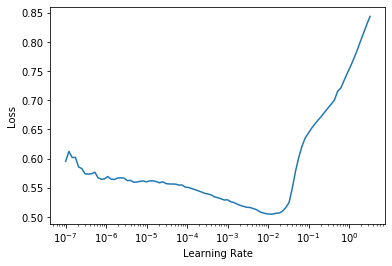

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, lr_max=1e-3, wd=1e-4)

epoch,train_loss,valid_loss,mae,time
0,0.392586,0.400923,0.400923,02:39
1,0.341680,0.373223,0.373223,02:50
2,0.312205,0.401886,0.401885,02:44
3,0.289967,0.280564,0.280564,02:47
4,0.274073,0.278581,0.278581,02:47
5,0.260590,0.259926,0.259926,02:54
6,0.263061,0.267341,0.267341,02:45
7,0.261221,0.246834,0.246834,02:41
8,0.249799,0.259108,0.259108,02:41
9,0.238088,0.242333,0.242333,02:53


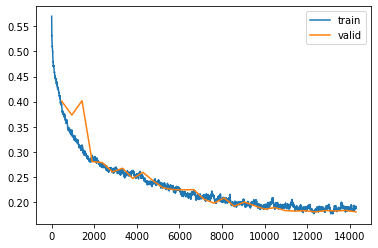

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save(f'reglstm_t{task}_dim{dim}_dm{dm}')

##### Validate the task

In [ ]:
learn.load(f'reglstm_{dim}')
validate_task([learn.model.cuda()], 1, [1])

#### Based on CNN
Using our CNN only

In [ ]:
dim = 1
dls = get_custom_dls(target='exp', dim=dim, bs=128)
cnn = CNNLin(dim, h_size=512, layers=[1, 1], ks=3, p=0.5, stem_szs=(32, 64))
learn = MyLearner(dls, cnn, loss_func=L1LossFlat(), metrics=mae)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=7.585775847473997e-07)

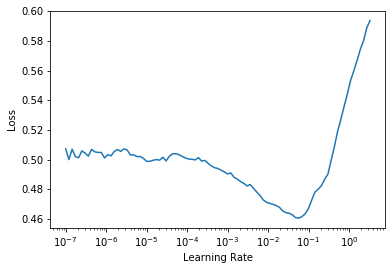

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=5e-3, wd=1e-3)

epoch,train_loss,valid_loss,mae,time
0,0.362033,0.342109,0.342109,00:09
1,0.310369,0.302907,0.302907,00:08
2,0.292476,0.273055,0.273055,00:08
3,0.276008,0.258261,0.258261,00:08
4,0.256228,0.255621,0.255621,00:09
5,0.254321,0.237205,0.237205,00:08
6,0.236969,0.231746,0.231746,00:09
7,0.243301,0.233111,0.233111,00:08
8,0.236128,0.228627,0.228627,00:09
9,0.222612,0.218090,0.218090,00:09


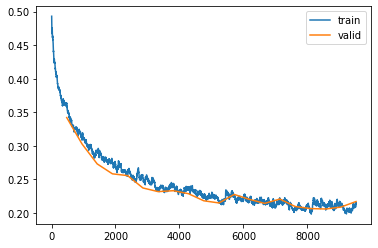

In [ ]:
learn.recorder.plot_loss()

### Combining RNN with CNN

In [ ]:
#export
class RNNCNNClassifier(Module):
    def __init__(self, dim, vocab_sz=1, rnn_h=750, rnn_layers=1, in_p=0.4, rnn_p=0.3, w_p=0.5, out_p=0.4, bidir=False, 
                 cnn_h=512, cnn_exp=1, cnn_layers=[1, 1, 1, 1], cnn_stemsz=(32, 64), cnn_ks=3, cnn_p=0.5, linear_layers=[200, 50], ps=None,
                 act=True, yrange=(0, 2.05), pad_value=0):
        store_attr('pad_value')
        self.rnn = RegLSTMLin(dim, rnn_h, vocab_sz=3*rnn_h, rnn_layers=rnn_layers, in_p=in_p, hid_p=rnn_p, weight_p=w_p, out_ps=out_p, 
                              linear_layers=[], bidir=bidir, act=False)
        self.cnn = CNN(dim, exp=cnn_exp, layers=cnn_layers, p=cnn_p, n_out=cnn_h, stem_szs=cnn_stemsz)
        
        lin_dim = [3*rnn_h + cnn_h] + linear_layers + [vocab_sz]
        if ps is None: ps = [0.2]*len(linear_layers)
        ps = [out_p] + ps
        self.linear = Classifier(lin_dim, ps=ps, act=act, yrange=yrange)
        self.blocks = [self.rnn, self.cnn, self.linear]
        
    def forward(self, x):
        mask = x == self.pad_value
        x = mask_normalisation(x, mask)
        out_rnn, out_cnn = self.rnn(x), self.cnn(x.permute(0, 2, 1))
        x = torch.cat([out_rnn[0].relu_(), out_cnn.relu_()], dim=1)
        x = self.linear(x)
        return x, out_rnn[1], out_rnn[2]

In [ ]:
dim = 1
dls = get_custom_dls(target='exp', dim=dim, bs=256)
rnn_cnn = RNNCNNClassifier(dim, vocab_sz=1, rnn_layers=2, in_p=0., rnn_p=0.1, w_p=0.01, out_p=0.3, ps=[0.4, 0.4], linear_layers=[500, 200])
learn = RNNLearner(dls, rnn_cnn, loss_func=L1LossFlat(), metrics=mae)

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.630780702224001e-05)

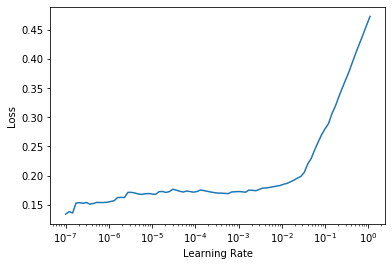

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, max_lr=5e-5, wd=1e-4)

epoch,train_loss,valid_loss,mae,time
0,0.174521,0.194923,0.194923,03:53
1,0.182383,0.198765,0.198765,03:51
2,0.177500,0.192314,0.192314,03:54
3,0.175523,0.189171,0.189171,03:52
4,0.172816,0.188006,0.188006,03:52


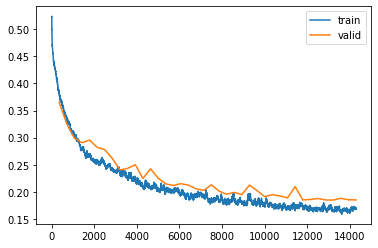

In [ ]:
learn.recorder.plot_loss()

In [ ]:
from pathlib import Path
path = Path(f"../models/rnncnn_dim{dim}_t{1}.pth")
torch.save(learn.model, path)

## Task 2 -- Classification

Task 2 consists on identifying the model with which the trajectories have been generated. The task is evaluated with F1 score (micro average). 

Here we don't have to worry about the output range. We provide an output neuron for each class, which provide the confidence that the trajectory belongs to each of those. For training, the `CrossEntropyLossFlat` already provides the last activation function for us. Nonetheless, we have to actually put the activation and take the argmax for validation. 

In [ ]:
dim = 1
dls = get_custom_dls(target='model', dim=dim, bs=256)
rnn_cnn = RNNCNNClassifier(dim, vocab_sz=5, rnn_layers=2, in_p=0., rnn_p=0.1, w_p=0.01, out_p=0.3, ps=[0.4, 0.4], linear_layers=[500, 200], act=False)
learn = RNNLearner(dls, rnn_cnn, loss_func=CrossEntropyLossFlat(), metrics=custom_f1)

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=4.786300905834651e-06)

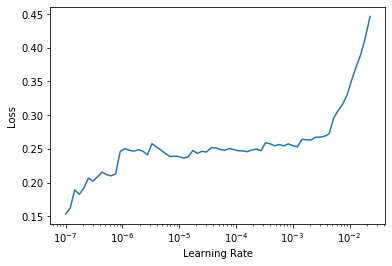

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, max_lr=2e-5, wd=1e-4)

epoch,train_loss,valid_loss,custom_f1,time
0,0.338405,0.542689,0.808914,04:01
1,0.288919,0.522555,0.804409,04:06


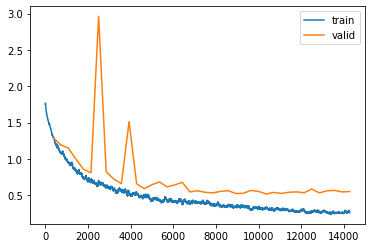

In [ ]:
learn.recorder.plot_loss()

In [ ]:
path = Path(f"../models/rnncnn_dim{dim}_t{2}.pth")
torch.save(learn.model, path)

In [ ]:
validate_task([learn.model], 2, [1], act=True)